## Import Packages  

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Upload Data and Indexing with Time

In [2]:
import pandas as pd
# Import the data
df = pd.read_csv("ForecastAnalyst_CalgaryDailyEnergyDataset.csv")
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.iloc[:1820,]
df['Energy'] = df['Energy'].fillna(df['Energy'].mean())
# Set the date as index 
df = df.set_index('Date')
# Select the proper time period for weekly aggreagation
df = df['2017-01-02':'2021-12-31'].resample('W').sum()
df = pd.DataFrame(df['Energy']).dropna()
df['Energy'] = df['Energy'].fillna(df['Energy'].mean())
df

,Energy
Date,
2017-01-08,8845.27
2017-01-15,8812.93
2017-01-22,8221.75
2017-01-29,8225.29
2017-02-05,8597.08
...,...
2021-11-28,7957.36
2021-12-05,8154.35
2021-12-12,8379.98


## Visulization the data 

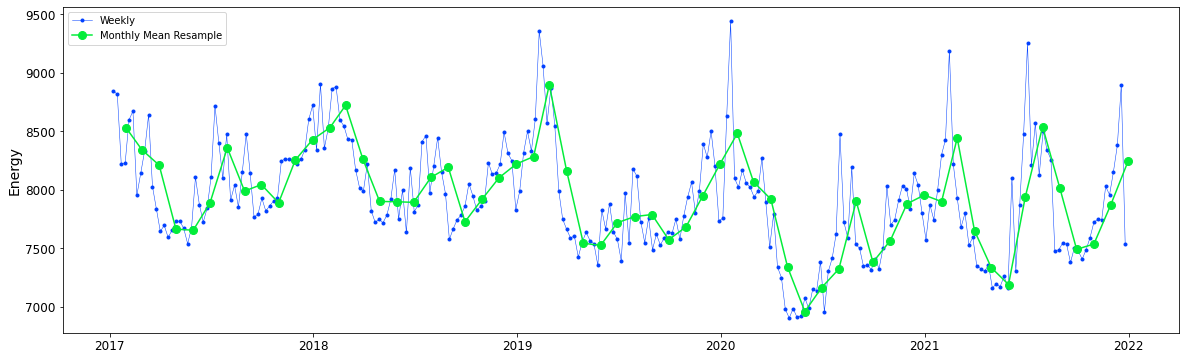

In [3]:
import warnings
import matplotlib.pyplot as plt
y = df['Energy']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Energy')
ax.legend();

## Decomposing the Data

In [4]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

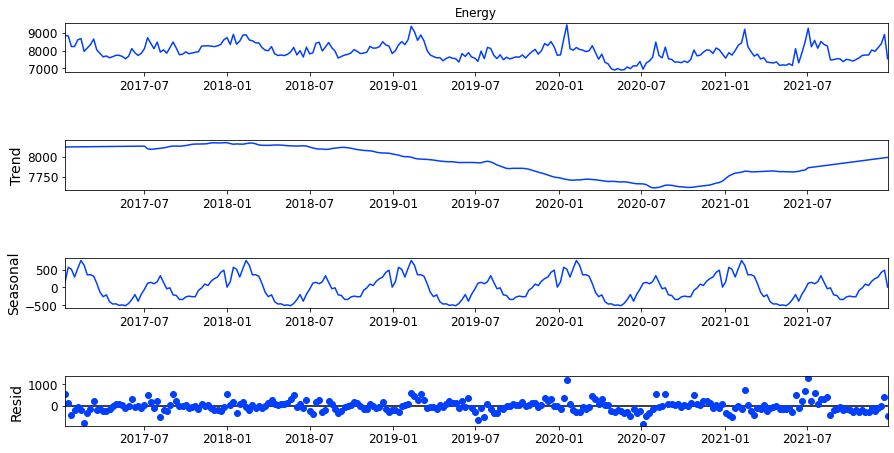

In [5]:
seasonal_decompose(y)

### Visualization: Graphing the rolling statistics

In [6]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    

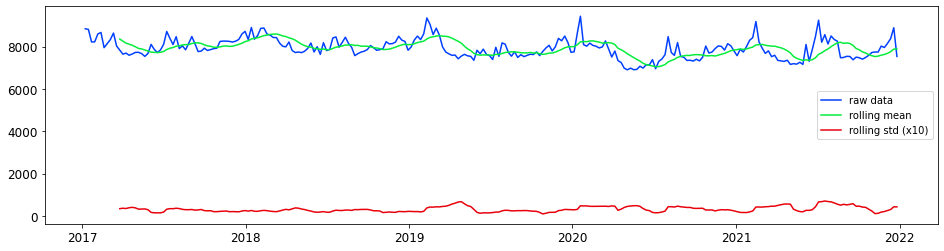

In [7]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

### Augmented Dickey-Fuller Test

In [8]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [9]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -4.495
P-value = 0.000
Critical values :
	1%: -3.4562572510874396 - The data is  stationary with 99% confidence
	5%: -2.8729420379793598 - The data is  stationary with 95% confidence
	10%: -2.5728461399461744 - The data is  stationary with 90% confidence


## Set the y_to_train, y_to_test, and the length of predict units 

In [10]:
y_to_train = y[:'2021-01-02'] # dataset to train
y_to_val = y['2021-01-03':] # last X months for test  
predict_date = len(y) - len(y[:'2021-01-03']) # the number of data points for the test set

## Different Time Series Prediction Models

### Simple Exponential Smoothing


In [11]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 508.03
The Root Mean Squared Error of our forecasts with auto optimization is 510.6


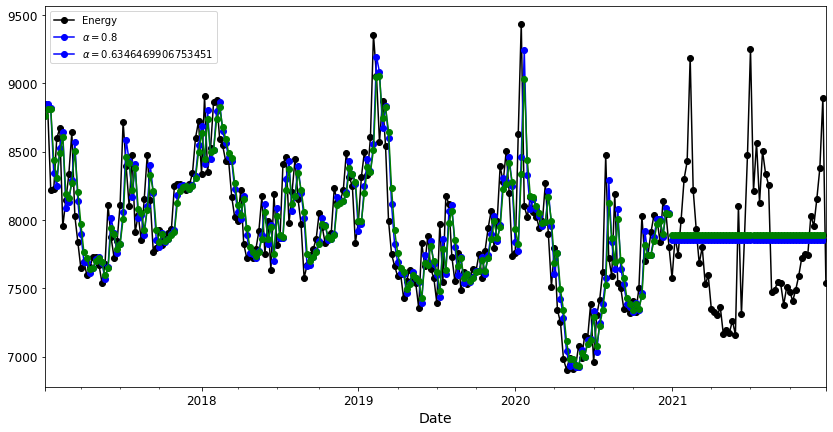

In [12]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

### Holt Winter's Seasonal Model

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)

    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
     
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 480.41


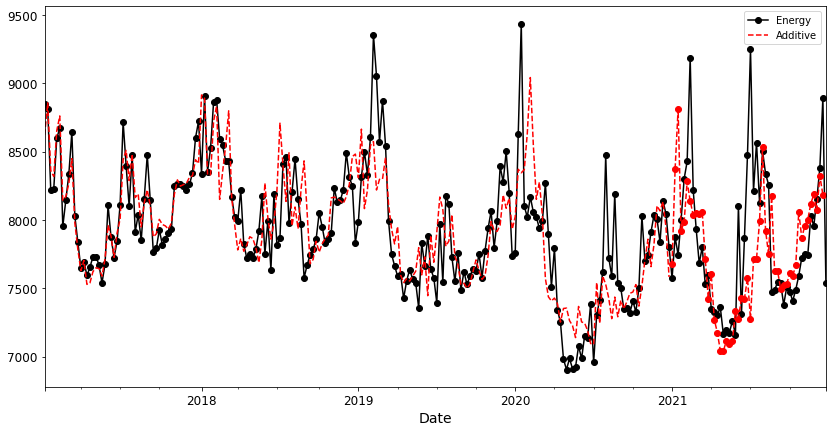

In [18]:
holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)

### SARIMA

In [35]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [36]:
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:2261.503901055762


In [42]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3159      0.098      3.236      0.001       0.125       0.507
ma.L1         -0.8697      0.050    -17.383      0.000      -0.968      -0.772
ar.S.L52      -0.5441      0.081     -6.736      0.000      -0.702      -0.386
sigma2      1.336e+05   1.11e+04     11.986      0.000    1.12e+05    1.55e+05


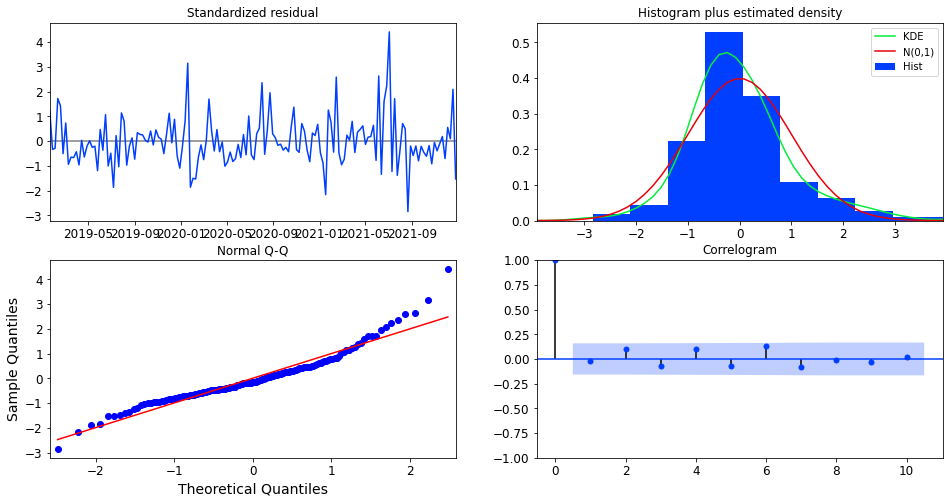

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 454.2


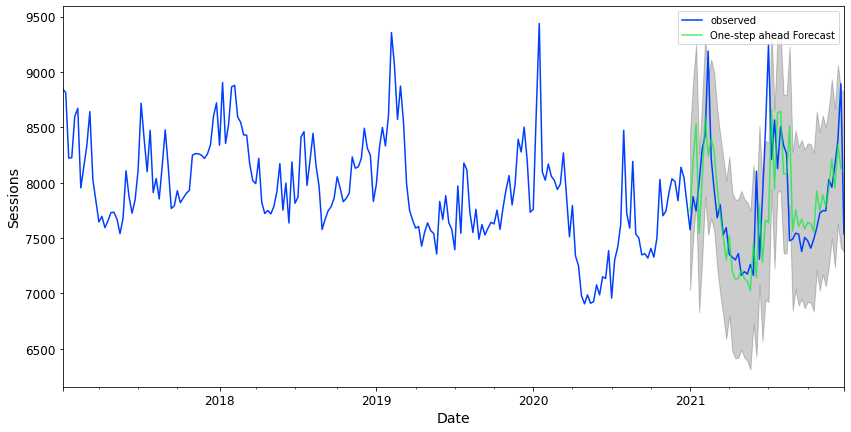

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 553.85


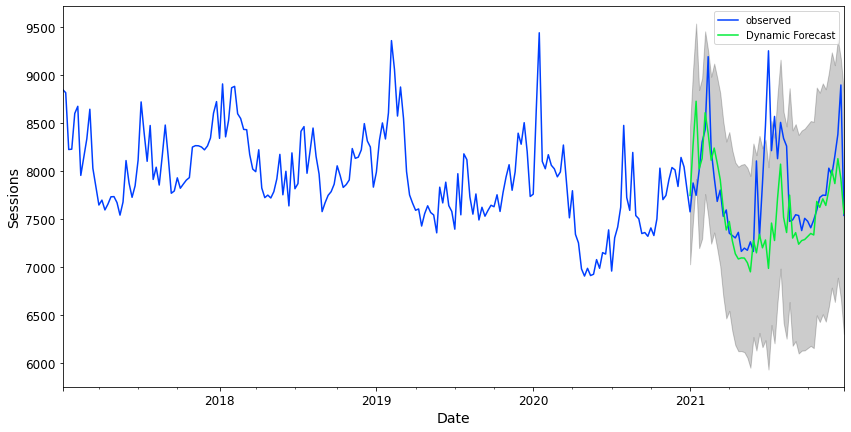

In [43]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2021-01-03',y_to_val)

In [55]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

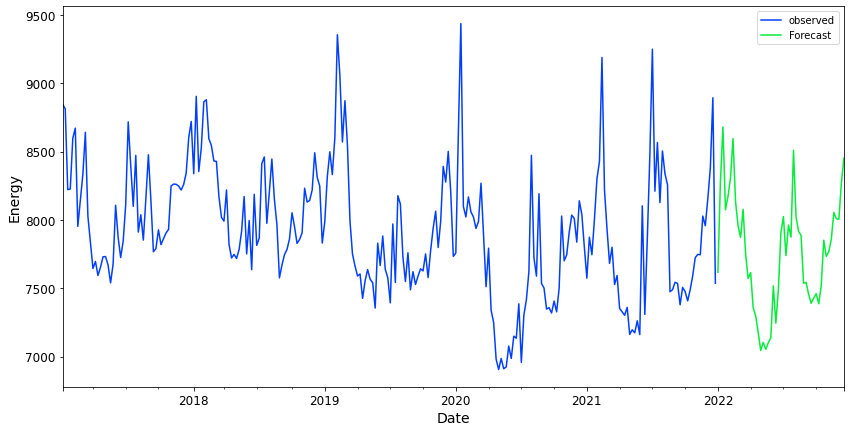

In [52]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

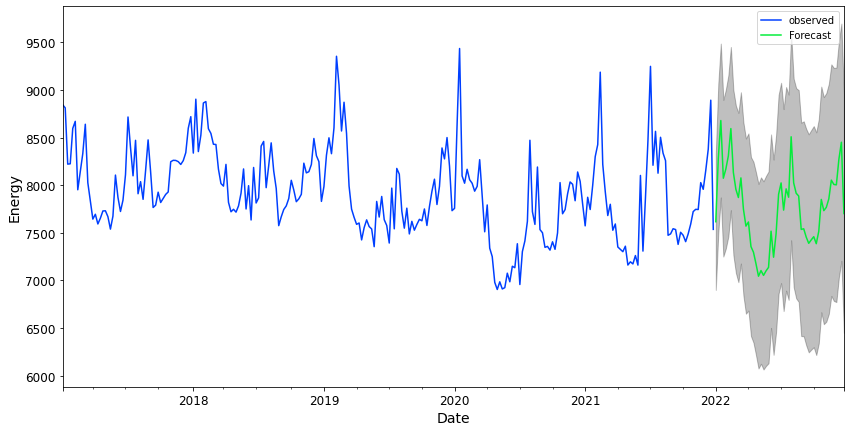

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-01-02,7616.83111892,6900.46284376,8333.19939409
1,2022-01-09,8282.39276309,7497.96589346,9066.81963272
2,2022-01-16,8679.82018246,7871.69657436,9487.94379055
3,2022-01-23,8073.74212358,7250.94966744,8896.53457971
4,2022-01-30,8170.24526658,7335.26094632,9005.22958683


In [56]:
final_table = forecast(model,52,y)
final_table.head()

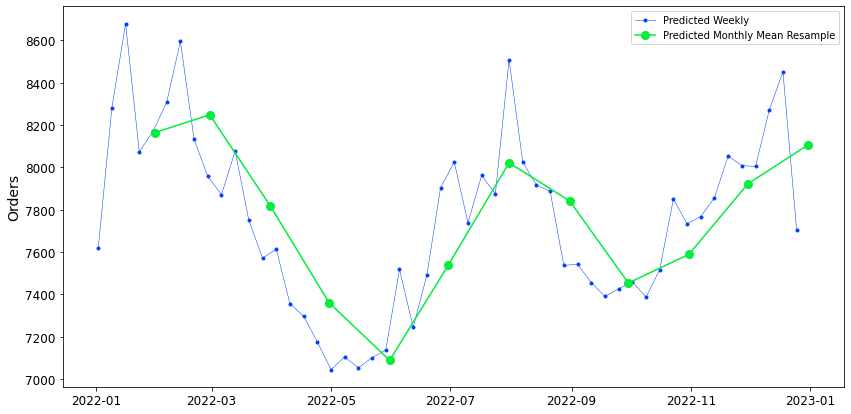

In [57]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();